### 1. Set up

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import math
from datasets import Dataset, Features, Array2D, Value, load_dataset, load_from_disk

/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/mazerl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded_data = load_from_disk(
        "/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/code-repo/dataset/test/21x21_test.hf"
    ).with_format("torch")

print(loaded_data.shape)
print(loaded_data[0])

(10000, 2)
{'maze': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0

In [3]:
batch_size = 4
testLoader = torch.utils.data.DataLoader(loaded_data, batch_size=4, shuffle=False)

classes = ('END', 'LEFT', 'RIGHT', 'UP', 'DOWN')

### 2. Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 7)
        
        self.fc1 = nn.Linear(16 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)
n = 21
summary(net, (1,n,n))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 16, 16]             222
         MaxPool2d-2              [-1, 6, 8, 8]               0
            Conv2d-3             [-1, 16, 2, 2]           4,720
         MaxPool2d-4             [-1, 16, 1, 1]               0
            Linear-5                  [-1, 120]           2,040
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 5]             425
Total params: 17,571
Trainable 

### 3. Test on finishing the maze

In [5]:
import numpy as np
from enum import Enum
from IPython.display import display

PATH = './maze_net21x21_even_label.pth'
net = Net()
net.load_state_dict(torch.load(PATH))

MAX_STEP_ALLOWED = 199

class MOVE_RESULT(Enum):
    OUT = "invalid - out of maze"
    WALL = "invalid - hit the wall"
    VALID = "valid move"
    WRONG_END = "wrong predicted goal! :<"
    GOAL = "reach goal! :>"
    TERMINATE = "killed! :<"
    MAX_STEP_REACHED = "reached the max step allowed, killed :<"

visualise some of of the test set

(tensor(57), tensor(77), tensor(81), tensor(53))

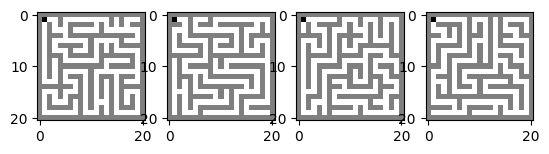

In [6]:
dataiter_test = iter(testLoader)
this_iter_test = next(dataiter_test)
this_iter_test['maze'], this_iter_test['steps']
# mazes, filenames, labels = next(dataiter)
# mazes
# this_iter

fig, axes = plt.subplots(1,4)
axes[0].imshow(this_iter_test['maze'][0].numpy(), cmap='binary')
axes[1].imshow(this_iter_test['maze'][1].numpy(), cmap='binary')
axes[2].imshow(this_iter_test['maze'][2].numpy(), cmap='binary')
axes[3].imshow(this_iter_test['maze'][3].numpy(), cmap='binary')

this_iter_test['steps'][0], this_iter_test['steps'][1], this_iter_test['steps'][2], this_iter_test['steps'][3]

In [7]:
def transform_tensor_maze(tensor_maze, maze_steps, show_maze = False):
    """ 
    tensor_maze: the direct output from loader, without reshaping
    maze_steps: the direct output from loader (number of steps it take)
    return: (test_torch_maze, test_numpy_maze, test_true_label, row_agent_idx, col_agent_idx)
    """
    test_torch_maze = tensor_maze.float().reshape(1, 1, n, n)
    test_numpy_maze = tensor_maze.numpy()
    test_true_step = maze_steps.item()

    print(" ==================================================================== ")

    if (show_maze):
        print(f"Testing maze .... ")
        fig = plt.figure()
        fig.add_subplot(111)
        plt.imshow(test_numpy_maze, cmap='binary')
        display(fig)
        plt.close()

    # find the index of the element with value = 2, which is the current location of the agent
    row_agent_array, col_agent_array = np.where(test_numpy_maze == 2)
    row_agent_idx = row_agent_array[0]
    col_agent_idx = col_agent_array[0]

    return (test_torch_maze, test_numpy_maze, test_true_step, row_agent_idx, col_agent_idx)


In [8]:
def move_agent(current_numpy_maze, current_row_idx, current_col_index, direction):

    new_maze = np.copy(current_numpy_maze)
    maze_size = current_numpy_maze.shape[0]

    if direction == 0: #END
        if current_col_index == maze_size - 2 and current_col_index == maze_size - 2:
            return (MOVE_RESULT.GOAL, current_row_idx, current_col_index)
        else:
            return (MOVE_RESULT.WRONG_END, current_row_idx, current_col_index)

    elif direction == 1: # LEFT
        if current_col_index == 0:
            return (MOVE_RESULT.OUT, current_row_idx, current_col_index)
        
        if new_maze[current_row_idx][current_col_index - 1] == 1:
            return (MOVE_RESULT.WALL, current_row_idx, current_col_index)
        
        new_maze[current_row_idx][current_col_index] = 0
        new_maze[current_row_idx][current_col_index - 1] = 2
        return (new_maze, current_row_idx, current_col_index - 1)
    
    elif direction == 2: # RIGHT
        if current_col_index == maze_size - 1:
            return (MOVE_RESULT.OUT, current_row_idx, current_col_index)
        if new_maze[current_row_idx][current_col_index + 1] == 1:
            return (MOVE_RESULT.WALL, current_row_idx, current_col_index)
        new_maze[current_row_idx][current_col_index] = 0
        new_maze[current_row_idx][current_col_index + 1] = 2
        return (new_maze, current_row_idx, current_col_index + 1)
    
    elif direction == 3: # UP
        if current_row_idx == 0:
            return (MOVE_RESULT.OUT, current_row_idx, current_col_index)
        if new_maze[current_row_idx - 1][current_col_index] == 1:
            return (MOVE_RESULT.WALL, current_row_idx, current_col_index)
        new_maze[current_row_idx][current_col_index] = 0
        new_maze[current_row_idx - 1][current_col_index] = 2
        return (new_maze, current_row_idx - 1, current_col_index)
    
    else: # DOWN
        if current_row_idx == maze_size - 1:
            return (MOVE_RESULT.OUT, current_row_idx, current_col_index)
        if new_maze[current_row_idx + 1][current_col_index] == 1:
            return (MOVE_RESULT.WALL, current_row_idx, current_col_index)
        new_maze[current_row_idx][current_col_index] = 0
        new_maze[current_row_idx + 1][current_col_index] = 2
        return (new_maze, current_row_idx +1, current_col_index)


In [9]:
def run_cnn_and_move(net, test_torch_maze, test_numpy_maze, row_agent_idx, col_agent_idx, show_step=False):
    output = net(test_torch_maze)
    _, prediction = torch.max(output, 1)
    prediction_label = prediction.item() 

    print(f"predicted: {prediction_label}-{classes[prediction_label]}")
    (new_numpy_maze, new_row_idx, new_col_idx) = move_agent(test_numpy_maze, row_agent_idx, col_agent_idx, prediction_label)
    if isinstance(new_numpy_maze, Enum):
        if new_numpy_maze == MOVE_RESULT.GOAL:
            print(" ---------- reached goal \U0001f600 ----------")
            return MOVE_RESULT.GOAL
        elif new_numpy_maze == MOVE_RESULT.WRONG_END:
            print(" ---------- wrong end, terminating \U0001f972 ----------")
            return MOVE_RESULT.WRONG_END
        else: #either goes into wall or out
            print(f"Invalid move - {new_numpy_maze}, killing \U0001f972")
            return MOVE_RESULT.TERMINATE
    else:
        if (show_step):
            fig, axes = plt.subplots(1,2)
            axes[0].imshow(test_numpy_maze, cmap='binary')
            axes[1].imshow(new_numpy_maze, cmap="binary")
            display(fig)
            plt.close()
        new_tensor_maze = torch.from_numpy(new_numpy_maze).float().reshape(1, 1, n, n)
        return (new_tensor_maze, new_numpy_maze, new_row_idx, new_col_idx)

In [10]:
def search_goal(starting_torch_maze, test_step, show_initial_maze = False, show_step = False):
    # necessary preprocessing
    (test_tensor_maze, test_numpy_maze, test_true_step, row_agent_idx, col_agent_idx) = transform_tensor_maze(starting_torch_maze, test_step, show_maze=show_initial_maze)

    step_counter = 0

    while True:
        move_result = run_cnn_and_move(net, test_tensor_maze, test_numpy_maze, row_agent_idx, col_agent_idx, show_step)
        step_counter += 1
        if step_counter >= MAX_STEP_ALLOWED:
            print(" ---------- could not find goal within MAX_STEP, terminating \U0001f92f ----------")
            print(f"Total steps taken: {step_counter}")
            return(MOVE_RESULT.MAX_STEP_REACHED, step_counter, test_true_step)
        elif isinstance(move_result, Enum):
            if move_result == MOVE_RESULT.GOAL:
                print(f"Total steps taken: {step_counter - 1}")
                return (MOVE_RESULT.GOAL, step_counter, test_true_step)
            elif move_result == MOVE_RESULT.TERMINATE:
                print(f"Total steps taken: {step_counter - 1}")
                return (MOVE_RESULT.TERMINATE, step_counter, test_true_step)
            else: 
                print(f"Total steps taken: {step_counter - 1}")
                return (MOVE_RESULT.WRONG_END, step_counter, test_true_step)
        else:
            # iterate
            test_tensor_maze = move_result[0]
            test_numpy_maze = move_result[1]
            row_agent_idx = move_result[2]
            col_agent_idx = move_result[3]


In [11]:
test_starting_tensor_maze = this_iter_test['maze'][0]
test_step = this_iter_test['steps'][0]

(search_result, num_steps, true_step) = search_goal(test_starting_tensor_maze, test_step, show_initial_maze=False, show_step=False)

predicted: 2-RIGHT
predicted: 2-RIGHT
predicted: 2-RIGHT
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2


#### 6.2 test an iter (4 mazes)

In [12]:
for i in range(4):
    print(f" ========= TESTING MAZE {i} =========")
    test_starting_tensor_maze = this_iter_test['maze'][i]
    test_label = this_iter_test['steps'][i]

    (search_result, num_steps, true_step) = search_goal(test_starting_tensor_maze, test_label, show_step=False)

 ========= TESTING MAZE 0 =========
predicted: 2-RIGHT
predicted: 2-RIGHT
predicted: 2-RIGHT
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2
 ========= TESTING MAZE 1 =========
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 0
 ========= TESTING MAZE 2 =========
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2
 ========= TESTING MAZE 3 =========
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2


#### 6.3 test the whole test dataset

In [13]:
def search_goal_testset():
    with torch.no_grad():

        num_total_mazes = 0
        num_found_goal = 0
        num_invalid_kill = 0
        num_max_step_reached = 0
        num_wrong_end = 0
        total_squared_error = 0
        total_number_step_accumulated = 0
        
        for current_data in testLoader:
            mazes = current_data['maze']
            labels = current_data['steps']
            this_batch_size = len(labels)

            # search goal for this batch
            for i in range(this_batch_size):
                test_starting_tensor_maze = mazes[i]
                test_label = labels[i]
                (search_result, num_steps, true_step) = search_goal(test_starting_tensor_maze, test_label, show_step=False)

                num_total_mazes += 1
                if search_result == MOVE_RESULT.MAX_STEP_REACHED:
                    num_max_step_reached += 1
                    total_number_step_accumulated += MAX_STEP_ALLOWED
                elif search_result == MOVE_RESULT.GOAL:
                    num_found_goal += 1
                    # record the squared error between the true number of steps
                    total_squared_error += (true_step - num_steps)**2
                    total_number_step_accumulated += num_steps
                elif search_result == MOVE_RESULT.TERMINATE:
                    num_invalid_kill += 1
                    total_number_step_accumulated += MAX_STEP_ALLOWED
                elif search_result == MOVE_RESULT.WRONG_END:
                    num_wrong_end += 1
                    total_number_step_accumulated += MAX_STEP_ALLOWED

        return {"Total test maze counts": num_total_mazes,
                "Num found goal": num_found_goal,
                "Num max step reached": num_max_step_reached,
                "Num invalid move, early kill": num_invalid_kill,
                "Num wrong end": num_wrong_end,
                "MSE for ones reached goal": total_squared_error/num_found_goal if num_found_goal > 0 else "NA",
                "Average number of steps take to find path": total_number_step_accumulated/num_total_mazes if num_total_mazes > 0 else "NA"}



In [14]:
test_find_goal_result = search_goal_testset()
test_find_goal_result

predicted: 2-RIGHT
predicted: 2-RIGHT
predicted: 2-RIGHT
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 0
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 2
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 0
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
Invalid move - MOVE_RESULT.WALL, killing 🥲
Total steps taken: 10
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
predicted: 4-DOWN
Invalid move - MOV

{'Total test maze counts': 10000,
 'Num found goal': 0,
 'Num max step reached': 73,
 'Num invalid move, early kill': 9927,
 'Num wrong end': 0,
 'MSE for ones reached goal': 'NA',
 'Average number of steps take to find path': 199.0}

In [22]:
found_goal_rate = test_find_goal_result["Num found goal"]/test_find_goal_result["Total test maze counts"]*100
print(f"Goal Rate: {found_goal_rate}%")

Goal Rate: 0.0%
